<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/MNIST_Circle_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Circle_Loss_MNIST**
https://cpp-learning.com/circle-loss/ <br>
https://github.com/TinyZeaMays/CircleLoss/blob/master/mnist_example.py <br>

In [2]:
import os
from typing import Tuple
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
 
import torch
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToTensor

use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
#DataLoader
def get_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.MNIST(
                                root="./data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)

# data loder
train_loader = get_loader(is_train=True, batch_size=64)
val_loader = get_loader(is_train=False, batch_size=64)




#Visualize Circle Loss
def visualize(features, labels, num_classes):
    # t-SNEで2次元に圧縮
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    features = tsne.fit_transform(features)
    
    # カラーマップ
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    # 描画
    for i in range(num_classes):
        plt.plot(features[labels == i, 0], features[labels == i, 1], '.', c=colors[i])

    # グラフ設定
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
    plt.show()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
#Define Circle Loss
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)

    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [5]:
#Make CNN Model
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )

    def forward(self, input: Tensor) -> Tensor:
        feature = self.feature_extractor(input).mean(dim=[2, 3])
        return nn.functional.normalize(feature)

In [33]:
#Trainng
def train(criterion, epoch):
    print("Training... Epoch = %d" % epoch)
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        model.zero_grad()
        pred = model(img)
        loss = criterion(*convert_label_to_similarity(pred, label))
        loss.backward()
        optimizer.step()

In [6]:
#Training
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, optimizer, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                preds = model(inputs)
                loss = criterion(*convert_label_to_similarity(preds, labels))

                # backward + optimize
                loss.backward()
                optimizer.step()

                # record training loss
                train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0
        #all_features, all_labels = [], []

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            # track history if only in train
            preds = model(inputs)
            loss = criterion(*convert_label_to_similarity(preds, labels))

            #all_features.append(preds.data.cpu().numpy())
            #all_labels.append(labels.data.cpu().numpy())

            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)

        """
        # 可視化
        all_features = np.concatenate(all_features, 0)
        all_labels = np.concatenate(all_labels, 0)
        visualize(all_features, all_labels, 10)
        """
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
# model
model_ft = Model().to(device)

# optimzer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer_ft, 20, gamma=0.8)

# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)

# Training
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=5, n_epochs=10)

"""
for epoch in range(20):
    sheduler.step()
    train(criterion, epoch+1)
"""

100%|██████████| 5000/5000 [00:09<00:00, 542.21it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


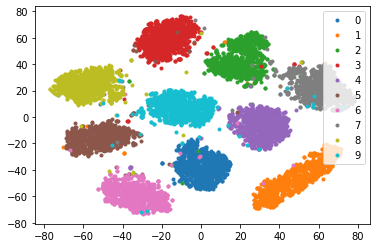

In [8]:
#Visualize results

# data loader
val_loader = get_loader(is_train=False, batch_size=2)

# 保存用
all_features = []
all_labels = []

# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model_ft(img)

    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)
visualize(all_features, all_labels, 10)

In [19]:
val_loader = get_loader(is_train=False, batch_size=2)

tp = 0
fn = 0
fp = 0
thresh = 0.75

for img, label in val_loader:
    img = img.to(device)
    pred = model_ft(img)
    gt_label = label[0] == label[1]
    pred_label = torch.sum(pred[0] * pred[1]) > thresh

    if gt_label and pred_label:
        tp += 1
    elif gt_label and not pred_label:
        fn += 1
    elif not gt_label and pred_label:
        fp += 1

print("Recall: {:.4f}".format(tp / (tp + fn)))
print("Precision: {:.4f}".format(tp / (tp + fp)))

Recall: 0.9580
Precision: 0.7760
